# View Raw Output Images
This notebook lets you open and visualize the contents of the `outputs` folder as grayscale images.

Available output files:
output_lena_512_512_raw
output_software_lena_512_512_raw


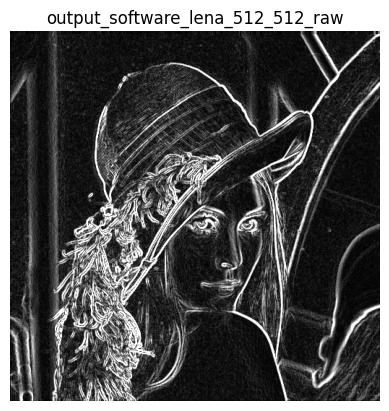

In [4]:
import os
from matplotlib import pyplot as plt
import numpy as np

# Path to outputs folder
outputs_dir = '../../data/outputs'

# List all files in outputs folder
output_files = [f for f in os.listdir(outputs_dir) if os.path.isfile(os.path.join(outputs_dir, f))]
print('Available output files:')
for f in output_files:
    print(f)

# Function to load and display a raw image

def show_raw_image(filename, width, height):
    path = os.path.join(outputs_dir, filename)
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    if data.size != width * height:
        print(f'Error: Expected {width*height} bytes, got {data.size}')
        return
    img = data.reshape((height, width))
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    plt.show()

# Example usage:
show_raw_image('output_software_lena_512_512_raw', 512, 512)
# show_raw_image('output_house_256_256_raw', 256, 256)

## How to use
- Run the first code cell to list available output files.
- Use `show_raw_image(filename, width, height)` to display any raw output file.
- Example: `show_raw_image('output_lena_512_512_raw', 512, 512)`

In [5]:
# Display original and processed images side by side
def show_comparison(raw_filename, output_filename, width, height):
    raw_path = os.path.join('../../data/raw', raw_filename)
    output_path = os.path.join(outputs_dir, output_filename)
    with open(raw_path, 'rb') as f:
        raw_data = np.frombuffer(f.read(), dtype=np.uint8)
    with open(output_path, 'rb') as f:
        out_data = np.frombuffer(f.read(), dtype=np.uint8)
    if raw_data.size != width * height or out_data.size != width * height:
        print(f'Error: Size mismatch. Raw: {raw_data.size}, Output: {out_data.size}, Expected: {width*height}')
        return
    raw_img = raw_data.reshape((height, width))
    out_img = out_data.reshape((height, width))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(raw_img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    axs[1].imshow(out_img, cmap='gray')
    axs[1].set_title('Processed')
    axs[1].axis('off')
    plt.suptitle(f'{raw_filename} vs {output_filename}')
    plt.show()

# Example usage:
show_comparison('lena_512_512_raw', 'output_lena_512_512_raw', 512, 512)

Error: Size mismatch. Raw: 262144, Output: 262136, Expected: 262144


In [6]:
# Compare original, hardware, and software outputs side by side
def show_multi_comparison(raw_filename, hw_filename, sw_filename, width, height):
    raw_path = os.path.join('../../data/raw', raw_filename)
    hw_path = os.path.join(outputs_dir, hw_filename)
    sw_path = os.path.join(outputs_dir, sw_filename)
    with open(raw_path, 'rb') as f:
        raw_data = np.frombuffer(f.read(), dtype=np.uint8)
    with open(hw_path, 'rb') as f:
        hw_data = np.frombuffer(f.read(), dtype=np.uint8)
    with open(sw_path, 'rb') as f:
        sw_data = np.frombuffer(f.read(), dtype=np.uint8)
    if raw_data.size != width * height or hw_data.size != width * height or sw_data.size != width * height:
        print(f'Error: Size mismatch. Raw: {raw_data.size}, HW: {hw_data.size}, SW: {sw_data.size}, Expected: {width*height}')
        return
    raw_img = raw_data.reshape((height, width))
    hw_img = hw_data.reshape((height, width))
    sw_img = sw_data.reshape((height, width))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(raw_img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    axs[1].imshow(hw_img, cmap='gray')
    axs[1].set_title('Hardware Output')
    axs[1].axis('off')
    axs[2].imshow(sw_img, cmap='gray')
    axs[2].set_title('Software Output')
    axs[2].axis('off')
    plt.suptitle(f'{raw_filename} | {hw_filename} | {sw_filename}')
    plt.show()

# Example usage:
show_multi_comparison('lena_512_512_raw', 'output_lena_512_512_raw', 'output_software_lena_512_512_raw', 512, 512)

Error: Size mismatch. Raw: 262144, HW: 262136, SW: 262144, Expected: 262144
